# Introduction

Set tests are a powerful approach for association testing between groups of genetic variants and quantitative traits.
In this tutorial we demonstrate how to use set tests within the LIMIX framework to test for association (mtSet) and genetic interactions with context (iSet).

# mtSet

Multi Trait Set test is an implementation of efficient set test algorithms for testing for associations between multiple genetic variants and multiple traits.
mtSet can account for confounding factors such as relatedness and can be used for analysis of single traits.
mtSet can be used both with the command line interface using the limix scripts (mtSet_preprocess, mtSet_analyze, mtSet_postprocess, mtSet_simPheno) or within python.

## Quick Start

In the following, we give a brief example on how to use mtSet. As a case study, we use a subset of the genotypes from the 1000 project [1] and simulated phenotypes.

All commands can be found in _demos/runmtSet.sh. In the following, we give a short summary of the individual steps. A demo for running mtSet-PC can be found in _demos/runmtSetPC.sh and it is not showcased here.
Go to the bin folder, create the output folder, set the filenames and parameters:

0. Our software depends on [Plink](https://www.cog-genomics.org/plink2) version 1.9 (or greater) for preprocessing. Please, make sure you have it before proceeding.

1. Download and install Limix
```bash
git clone --depth 1 https://horta@scm.ebi.ac.uk/git/limix.git
pushd limix
python setup.py install
popd
```

2. Download tutorial
```bash
git clone --depth 1 https://github.com/PMBio/private-limix-tutorials.git
cd private-limix-tutorials/mtSet
python download_examples.py
cd data
mkdir out
ls 1000g/
```

3. Set some handy shell variables
```bash
BFILE=1000g/chrom22_subsample20_maf0.10
CFILE=out/chrom22
PFILE=1000g/pheno
WFILE=out/windows
NFILE=out/null
WSIZE=30000
RESDIR=out/results
OUTFILE=out/final
```

4. Preprocess and phenotype simulation
```bash
# Kinship matrix estimation
mtSet_preprocess --compute_covariance --bfile $BFILE --cfile $CFILE 
# Fitting the null model and assigning the markers to windows
mtSet_preprocess --precompute_windows --fit_null --bfile $BFILE --cfile $CFILE --pfile $PFILE --wfile $WFILE --nfile $NFILE --window_size $WSIZE --plot_windows
```

5. Analysing true genotypes
```bash
mtSet_analyze --bfile $BFILE --cfile $CFILE --pfile $PFILE --nfile $NFILE --wfile $WFILE --minSnps 4 --resdir $RESDIR --start_wnd 0 --end_wnd 100
```

6. Analysing permuted genotypes
```bash
for i in `seq 0 10`; do
    mtSet_analyze --bfile $BFILE --cfile $CFILE --pfile $PFILE --nfile $NFILE --wfile $WFILE --minSnps 4 --resdir $RESDIR --start_wnd 0 --end_wnd 100 --perm $i
done
```

7. Postprocess
```bash
mtSet_postprocess --resdir $RESDIR --outfile $OUTFILE --manhattan_plot
```

### Processing

Before getting started, we have to compute the sample-to-sample genetic covariance matrix, assign the markers to windows and estimate the trait-to-trait covariance matrices on the null model.

#### Computing the Covariance Matrix
The covariance matrix can be pre-computed as follows:

```bash
mtSet_preprocess --compute_covariance --plink_path plink_path  --bfile bfile  --cfile cfile
```

where
* __plink\_path__ (default: plink) is a pointer to the [plink software](https://www.cog-genomics.org/plink2) (Version 1.9 or greater must be installed).
  If not set, a python covariance reader is employed.
  We strongly recommend using the plink reader for large datasets.
* __bfile__ is the base name of of the binary bed file (__bfile__.bed, __bfile__.bim, __bfile__.fam are required).
* __cfile__ is the base name of the output file.
  The relatedness matrix will be written to __cfile__.cov while the identifiers of the individuals are written to the file __cfile__.cov.id.
  The eigenvalue decomposition of the matrix is saved in the files __cfile__.cov.eval (eigenvalues) and __cfile__.cov.evec (eigenvectors).
  If __cfile__ is not specified, the files will be exported to the current directory with the following filenames __bfile__.cov, __bfile__.cov.id, __bfile__.cov.eval, __bfile__.cov.evec.

#### Precomputing the Principal Components 
The principal components can be pre-computed as follows:

```bash
mtSet_preprocess --compute_PCs k --plink_path plink_path --ffile ffile  --bfile bfile
```

where
* __k__ is the number of top principal components that are saved
* __plink\_path__ (default: plink) is a pointer to the [plink software](https://www.cog-genomics.org/plink2) (Version 1.9 or greater must be installed).
  If not set, a python genotype reader is employed.
  We strongly recommend using the plink reader for large datasets.
* __ffile__ is the name of the fixed effects file, to which the principal components are written to.
* __bfile__ is the base name of of the binary bed file (__bfile__.bed, __bfile__.bim, __bfile__.fam are required).


#### Fitting the null model

To efficiently apply mtSet, it is neccessary to compute the null model beforehand.
This can be done with the following command:

```bash
mtSet_preprocess --fit_null --bfile bfile --cfile cfile --nfile nfile --pfile pfile --ffile ffile --trait_idx trait_idx
```

where
* __bfile__ is the base name of of the binary bed file (_bfile_.bed,_bfile_.bim,_bfile_.fam are required).
* __cfile__ is the base name of the covariance file and its eigen decomposition (__cfile__.cov, __cfile__.cov.eval and __cfile__.cov.evec).
If __cfile__ is not set, the relatedness component is omitted from the model.
* __nfile__ is the base name of the output file.
The estimated parameters are saved in __nfile__.p0, the negative log likelihood ratio in __nfile__.nll0, the trait-to-trait genetic covariance matrix in __nfile__.cg0 and the trait-to-trait residual covariance matrix in __nfile__.cn0. 
* __pfile__ is the base name of the phenotype file.
* __ffile__ is the name of the file containing the covariates. Each covariate is saved in one column
* __trait\_idx__ can be used to specify a subset of the phenotypes. If more than one phenotype is selected, the phenotypes have to be seperated by commas. For instance, `--trait_idx 3,4` selects the phenotypes saved in the forth and fifth column (indexing starts with zero).

Notice that phenotypes are standardized prior to model fitting.

#### Precomputing the windows
For applying our set test, the markers have to be assigned to windows. We provide a method that splits the genome in windows of fixed sizes:

```bash
mtSet_preprocess --precompute_windows --bfile bfile --wfile wfile --window_size window_size --plot_windows
```

where
* __bfile__ is the base name of of the binary bed file (__bfile__.bim is required).
* __window\_size__ is the size of the window (in basepairs). The default value is 30kb.
* __wfile__ is the base name of the output file.
  If not specified, the file is saved as __bfile__.window\_size.wnd in the current folder.
  Each window is stored in one line having the following format: index, chromosome, start position, stop position, index of startposition and number of SNPs.
* __plot\_windows__ if the flag is set, a histogram over the number of markers within a window is generated and saved as __wfile__.pdf.

#### Merging the preprocessing steps

Here, we provided the commands to execute the three preprocessing operations individually. However, it is also possible to combine all steps in a single command:

```bash
mtSet_preprocess --compute_covariance --fit_null --precompute_windows ...
```

### Phenotype simulation

Our software package also includes a command-line simulator that allows to generate phenotypes with a wide range of different genetic architectures.
In brief, the simulator assumes a linear-additive model, considering the contribution of a randomly selected (causal) genetic region for the set component, polygenic background effects from all remaining genome-wide variants, a contribution from unmeasured factors and iid observation noise.
For a detailed description of the simulation procedure, we refer to the Supplementary Methods. 

The simulator requires as input the genotypes and the relatedness component:

```bash
mtSet_simPheno --bfile bfile --cfile cfile --pfile pfile
```

where
* __bfile__ is the name of of the binary bed file (__bfile__.bed, __bfile__.bim, __bfile__.fam are required).
* __cfile__ is the name of the covariance matrix file (__cfile__.cov, __cfile__.cov.id are required).
If none is specified, the covariance matrix is expected to be in the current folder, having the same filename as the bed file.
* __pfile__ is the name of the output file (__pfile__.phe, __pfile__.region).
The file __pfile__.phe contains the phenotypic values (each sample is saved in one row, each trait in one column).
The file __pfile__.region contains the randomly selected causal region (chromsom, start position, end position). 
If __pfile__ is not specified, the files are saved in the current folder having an automatic generated filename containing the bed filename and the values of all simulation parameters.

By changing the following parameters different genetic architectures can be simulated and, in particular, the simulation experiments of our paper can be reproduced.


| Option        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| _--seed_       | 0 | int | seed for random number generator |
| _--nTraits_    | 4 | int | number of simulated phenotypes |
| _--windowSize_ | 1.5e4 | int | size of causal region |
| _--vTotR_ | 0.05 | float |   variance explained by the causal region |
| _--nCausalR_  | 10 | int |   number of causal variants in the region |
| _--pCommonR_ | 0.8 | float | percentage of shared causal variants |
| _--vTotBg_ | 0.4 | float  | variance explained by the polygenic background effects |
| _--pHidden_ | 0.6 | float | residual variance explained by hidden confounders (in %) |
| _--pCommon_ | 0.8 | float | background and residual signal that is shared across traits (in %) |
| _--chrom_ | None | int | specifies the chromosome of the causal region |
| _--minPos_ | None | int | specifies the min. chromosomal position of the causal region (in basepairs) |
| _--maxPos_ | None | int | specifies the max. chromosomal position of the causal region (in basepairs) |

### Running mtSet

Once the preprocessing step has been used to obtain the genetic relatedness matrix, to fit the null model and to identify the genetic regions to be considered in the analysis, the set test can be run by the following analysis script:

```bash
mtSet_analyze --bfile bfile --cfile cfile --pfile pfile --nfile nfile --wfile wfile --ffile ffile --minSnps minSnps --start_wnd start_wnd --end_wnd end_wnd --resdir rdir --trait_idx traitIdx
```

where

- __bfile__ is the base name of of the binary bed file (bfile.bed,bfile.bim,bfile.fam are required).
- __cfile__ is the base name of the covariance matrix file. The script requires the files: cfile.cov containing the the genetic relatedness matrix, cfile.cov.id containing the corresponding sample identifiers, cfile.cov.eval and _cfile.cov.evec containing the eigenvalues and eigenvectors of the matrix. If cfile is not set, the relatedness component is omitted from the model.
- __pfile__ is the base name of the phenotype file. The script requires the file pfile.phe containing the phenotype data.
- __nfile__ is the base name of the null model file. The script requires the file nfile.p0 containing the optimal null model parameters. If covariates are set, it also requires the file nfile.f0.
- __wfile__ is the base name of the file containing the windows to be considered in the set test. The script requires the file wfile.wnd.
- __ffile__ is the name of the file containing the covariates. Each covariate is saved in one column.
- __perm__ is the seed used when permuting the genotypes. If the option is not specified then no permutation is considered.
- __start\_wnd__ is the index of the start window
- __end\_wnd__ is the index of the end window
- __minSnps__ if set only windows containing at least minSnps are considered in the analysis
rdir is the directory to which the results are exported. The results are exported in the folder rdir/perm if a permutation seed has been set, otherwise in the folder rdir/test. The output file is named - _start_wnd_endwnd.res and contains results in the following format: window index, chromosome, start position, stop position, index of startposition, number of SNPs and log likelihood ratio.
- __rdir__ is the directory to which the results are exported. The results are exported in the folder rdir/perm if a permutation seed has been set, otherwise in the folder rdir/test. The output file is named start_wnd_end_wnd.res and contains results in the following format: window index, chromosome, start position, stop position, index of startposition, number of SNPs and log likelihood ratio.
- __trait\_idx__ can be used to specify a subset of the phenotypes. If more than one phenotype is selected, the phenotypes have to be seperated by commas. For instance _traitidx 3,4 selects the phenotypes saved in the forth and fifth column (indexing starts with zero).
Notice that phenotypes are standardized prior to model fitting.

### Postprocessing

After running mtSet, the following script can be used to merge the result files and estimate the p-values (p-values are obtained by a parametric fit of the test statistics): 

```bash
mtSet_postprocess --resdir resdir --outfile outfile --manhattan_plot
```

where 
* __resdir__ is a pointer to the folder containing the result files of the analysis.
* __outfile__ is the prefix of the two output files.
_outfile_.perm lists the test statistics (first column) and p-values (second column) of the permutated windows
_outfile_.test contains the (index, chromosome, start position, stop position, SNP index, number of SNPs, test statistics and p-value) of each window. Each window is saved in one row.
* __manhattan\_plot__ is a flag. If set, a manhattan plot is saved in outfile.manhattan.jpg (default: False).

## Within Python

This tutorial shows how to use mtSet within python.
For a tutorial on how to use mtSet from the command line using the limix scripts (mtSet_preprocess, mtSet_analyze, mtSet_postprocess, mtSet_simPheno) please refer to the tutorials:
* [Tutorial on how to use mtSet from command line](mtSet_scripts.ipynb)
* [Example for command line usage](example_usage.ipynb)



### Setting up

In [19]:
# activiate inline plotting
%matplotlib inline

from download_examples import get_1000G_mtSet
import scipy as sp
import scipy.linalg
import limix

In [20]:
# loading 1000G genotypes for mtSet demo
get_1000G_mtSet()

In [21]:
# base name for bed, bim and fam
bfile = './data/1000g/chrom22_subsample20_maf0.10'

### Split genotypes into regions

In [22]:
from limix.mtSet.core import plink_reader

In [23]:
# import genotype positions
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
chrom = bim[:, 0].astype(float)
pos = bim[:, -1].astype(float)

In [24]:
# uses splitter to split the genotypes
from limix.mtSet.core.splitter import Splitter
split = Splitter(pos=pos,chrom=chrom)

The method __splitGeno__ allows to define the regions that will then considered for the analysis with mtSet.
Information relative to the calculated regions can be cached in an external file by activating the cache option (see below).

| Argument        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| _method_      | 'slidingWindow' | str | Uses a sliding window approach to define regions (a region-based approach will be availabe soon) |
| _size_      | 5E+04 (50kb) | float | Window size. Pace is set at half the size of the window |
| _minSnps_      | 1 | int | Windows with number of SNPs lower that this threshold are not considered |
| _maxSnps_      | sp.inf | int | Windows with number of SNPs higher that this threshold are not considered |
| _cache_       | False | bool | If true, it activates the caching |
| _out_dir_     | './cache' | str | outdir of the cache file |
| _fname_       | None | str | Name of the file |
| _rewrite_     | False | bool | If true and the cache file already exists, the cache file is overwritten |

In [25]:
split.splitGeno(cache=True, fname='regions.h5', minSnps=4)
print '%d windows' % split.nWindows

1380 windows


### Apply

In this paragraph we showcase how to construct the mtSet class that will then be used for the set test analysis. We showcase both the full mtSet that models relatedness as random effect by the means of an individual-to-individual covariance matrix and the approximated model (mtSetPC) that models relatedness as fixed effect using principal component from the covariance.

In [26]:
# import phenotype and sample relatedness
pheno_file = './data/1000g/pheno.phe'
sample_relatedness_file = './data/1000g/chrom22.cov'
Y = sp.loadtxt(pheno_file)
R = sp.loadtxt(sample_relatedness_file)

In [27]:
# compute eigenvalues and eigenvectors of the sample relatedness matrix
S_R, U_R = scipy.linalg.eigh(R) # these are needed for the full mtSet model

In [28]:
# caculate fixed effects with rel
F = U_R[:, ::-1][:, :10] # it considered the first 10 PCs
F = sp.concatenate([F, sp.ones((F.shape[0], 1))], 1) # add an intercept term

In [29]:
if 0:
    # use full mtSet implementation
    # (relatedness is modeled as random effect by the means of
    # an individual-to-individual covariance matrix)
    mtSet = limix.MTSet(Y, S_R=S_R, U_R=U_R)
else:
    # use mtSetPC
    # (relatedness s modelled as fixed effect
    # using principal component from the covariance)
    mtSet = limix.MTSet(Y, F=F)

### Null model

If the analysis is parallelized across different set of regions and permutations,
it might be convenient to cache the results from the optimization of the null model
(as the null model need to be optimized only once).

| Argument        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| _cache_       | False | bool | If true, it activates the caching |
| _out\_dir_     | './cache' | str | outdir of the cache file |
| _fname_       | None | str | Name of the file |
| _rewrite_     | False | bool | If true and the cache file already exists, the cache file is overwritten |

In [30]:
RV = mtSet.fitNull()

The returned dictionary contains:
* __B__: value of the optimized effect sizes
* __Cg__: value of the genetic trait-to-trait covariance
* __Cn__: value of the residual trait-to-trait covariance
* __conv__: bool that indicates convergence of the optimization
* __time__: time elpased for optimizing the parameters
* __NLL0__: negative log likelihood of the null model
* __LMLgrad__: norm of the gradient of the negative log likelihood dividived by the number of parameters

### Test

In [31]:
# read fam
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
fam = plink_reader.readFAM(bfile,usecols=(0,1))

In [32]:
n_wnds = 100 # only hundred windows are considered
LLR = sp.zeros(n_wnds) # vector with test statistics of the n_wnds regions
for wnd_i in range(n_wnds):
    wnd_pos = split.wnd_pos[wnd_i]
    nSnps = split.nSnps[wnd_i]
    idx_wnd_start = split.idx_wnd_start[wnd_i]
    print('.. window %d - (%d, %d-%d) - %d snps' % (wnd_i, wnd_pos[0], wnd_pos[1], wnd_pos[2], nSnps))
    
    Xr = plink_reader.readBED(bfile, useMAFencoding=True, start = idx_wnd_start, nSNPs = nSnps, bim=bim , fam=fam)['snps']

    # multi trait set test fit
    RV = mtSet.optimize(Xr)
    LLR[wnd_i] = RV['LLR'][0]

.. window 0 - (22, 16025000-16075000) - 21 snps
.. window 1 - (22, 16050000-16100000) - 23 snps
.. window 2 - (22, 16125000-16175000) - 7 snps
.. window 3 - (22, 16225000-16275000) - 9 snps
.. window 4 - (22, 16250000-16300000) - 16 snps
.. window 5 - (22, 16275000-16325000) - 12 snps
.. window 6 - (22, 16325000-16375000) - 5 snps
.. window 7 - (22, 16350000-16400000) - 5 snps
.. window 8 - (22, 16475000-16525000) - 8 snps
.. window 9 - (22, 16500000-16550000) - 7 snps
.. window 10 - (22, 16550000-16600000) - 5 snps
.. window 11 - (22, 16600000-16650000) - 13 snps
.. window 12 - (22, 16625000-16675000) - 18 snps
.. window 13 - (22, 16650000-16700000) - 10 snps
.. window 14 - (22, 16825000-16875000) - 46 snps
.. window 15 - (22, 16850000-16900000) - 75 snps
.. window 16 - (22, 16875000-16925000) - 68 snps
.. window 17 - (22, 16900000-16950000) - 62 snps
.. window 18 - (22, 16925000-16975000) - 43 snps
.. window 19 - (22, 16950000-17000000) - 22 snps
.. window 20 - (22, 16975000-17025000

The returned dictionary from _mtSet.optimize_ contains:
* __Cr__: value of the region-term trait-to-trait covariance
* __Cg__: value of the genetic trait-to-trait covariance
* __Cn__: value of the residual trait-to-trait covariance
* __variances__: n_traits-by-3 matrix of variance explained by the three contributions (region, background, noise) for the  traits
* __conv__: bool that indicates convergence of the optimization
* __time__: time elpased for optimizing the parameters
* __NLLAlt__: negative log likelihood of the alternative model
* __LLR__: test statistics
* __LMLgrad__: norm of the gradient of the negative log likelihood dividived by the number of parameters

### P-values

P values are obtained from a relatively small number of genome-wide permutations, fitting a parametric model to the null distribution. Here we showcase the permutation procedure by considering 10 permutations for the 10 regions analyzed.

In [33]:
n_perms = 10
LLR_null = [] # in this list test statistics from permutations will be stored
for perm_i in range(n_perms):
    
    #1. generate permutation
    print 'permutation %d' % perm_i
    sp.random.seed(perm_i)
    perm_idxs = sp.random.permutation(Y.shape[0])
    
    #2. scan on the 100 regions
    for wnd_i in range(n_wnds):
        wnd_pos = split.wnd_pos[wnd_i]
        nSnps = split.nSnps[wnd_i]
        idx_wnd_start = split.idx_wnd_start[wnd_i]
        Xr = plink_reader.readBED(bfile, useMAFencoding=True, start = idx_wnd_start, nSNPs = nSnps, bim=bim , fam=fam)['snps']
        Xr = Xr[perm_idxs, :] # permute samples in region term
        RV = mtSet.optimize(Xr)
        LLR_null.append(RV['LLR'][0])
LLR_null = sp.array(LLR_null)

permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9


The parametric fit to the ditribution of the test statistics under the null and the consequent conversion of the observed test statistics in P values is performed by the module `limix.stats.chi2mixture` as shown below.

In [34]:
from limix.stats.chi2mixture import Chi2mixture
c2m = Chi2mixture(tol=4e-3)
c2m.estimate_chi2mixture(LLR_null)
pv = c2m.sf(LLR)

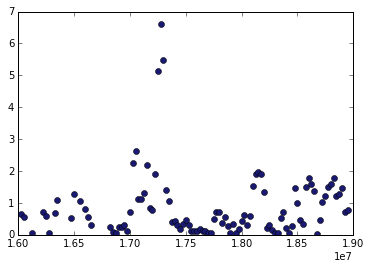

In [35]:
#makes a manhattan plot
wnd_chrom = split.wnd_pos[:n_wnds,0]
wnd_start = split.wnd_pos[:n_wnds,1]
wnd_end = split.wnd_pos[:n_wnds,2]
import pylab as pl
pl.plot(wnd_start, -sp.log10(pv), 'o', color='MidnightBlue')

# iSet

Interaction Set test is an extension of mtSet to test for gene-context interactions.
Currently iSet can only be used within python, but a command line interface will be available soon.
As we show in this tutorial, iSet can be applied for interaction analysis in two data designs:
* [Complete design](#Complete-design), where all individuals have been phenotyped in each context
* [Stratified design](#Stratified-design), where each individual has been phenotyped only in one of the two contexts.


## Complete design

### Within Python

iSet is an extension of mtSet that allows to test for polygenic interactions with environment or other contexts. iSet can be applied in designs where all individuals have been phenotyped in each context (complete design) as well as for populations that have been stratified by a context variable (stratified design). We will here see application of iSet for analysis of complete designs, please look here for analysis of stratified designs.

### Setting up

In [39]:
# activiate inline plotting
%matplotlib inline

from download_examples import get_1000G_mtSet
import scipy as sp
import scipy.linalg
import limix
from limix.mtSet.iset import fit_iSet
import pandas as pd

In [40]:
# loading 1000G genotypes for mtSet demo
get_1000G_mtSet()

In [41]:
# base name for bed, bim and fam
bfile = './data/1000g/chrom22_subsample20_maf0.10'

### Split genotypes into regions

In [42]:
from limix.mtSet.core import plink_reader

In [43]:
# import genotype positions
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
chrom = bim[:, 0].astype(float)
pos = bim[:, -1].astype(float)

In [44]:
# uses splitter to split the genotypes
from limix.mtSet.core.splitter import Splitter
split = Splitter(pos=pos,chrom=chrom)

The method _splitGeno_ allows to define the regions that will then considered for the analysis with mtSet.
Information relative to the calculated regions can be cached in an external file by activating the cache option (see below).

| Argument        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| _method_      | 'slidingWindow' | str | Uses a sliding window approach to define regions (a region-based approach will be availabe soon) |
| _size_      | 5E+04 (50kb) | float | Window size. Pace is set at half the size of the window |
| _minSnps_      | 1 | int | Windows with number of SNPs lower that this threshold are not considered |
| _maxSnps_      | sp.inf | int | Windows with number of SNPs higher that this threshold are not considered |
| _cache_       | False | bool | If true, it activates the caching |
| _out_dir_     | './cache' | str | outdir of the cache file |
| _fname_       | None | str | Name of the file |
| _rewrite_     | False | bool | If true and the cache file already exists, the cache file is overwritten |

In [45]:
split.splitGeno(cache=True, fname='regions.h5', minSnps=4)
print '%d windows' % split.nWindows

1380 windows


### Apply

In [46]:
# import phenotype and sample relatedness
pheno_file = './data/1000g/pheno.phe'
sample_relatedness_file = './data/1000g/chrom22.cov'
Y = sp.loadtxt(pheno_file)[:,:2]
R = sp.loadtxt(sample_relatedness_file)

In [47]:
# compute eigenvalues and eigenvectors of the sample relatedness matrix
S_R, U_R = scipy.linalg.eigh(R+1e-4*sp.eye(R.shape[0])) # these are needed for the full mtSet model

In [48]:
# read fam
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
fam = plink_reader.readFAM(bfile,usecols=(0,1))

In [50]:
n_wnds = 10 # only 10 windows are considered
LLR = sp.zeros(n_wnds) # vector with test statistics of the n_wnds regions
df = pd.DataFrame()
df0 = pd.DataFrame()
import time
t0 = time.time()
for wnd_i in range(n_wnds):
    wnd_pos = split.wnd_pos[wnd_i]
    nSnps = split.nSnps[wnd_i]
    idx_wnd_start = split.idx_wnd_start[wnd_i]
    print '.. window %d - (%d, %d-%d) - %d snps' % (wnd_i, wnd_pos[0], wnd_pos[1], wnd_pos[2], nSnps)
    
    Xr = plink_reader.readBED(bfile, useMAFencoding=True, start = idx_wnd_start, nSNPs = nSnps, bim=bim , fam=fam)['snps']
    Xr-= Xr.mean(0)
    Xr/= Xr.std(0)
    Xr/= sp.sqrt(Xr.shape[1])
    
    _df, _df0 = fit_iSet_full(Y, U_R, S_R, Xr, n_perms=10)
    df  = df.append(_df)
    df0 = df0.append(_df0)
print 'Elapsed:', time.time()-t0

.. window 0 - (22, 16025000-16075000) - 21 snps


NameError: name 'fit_iSet_full' is not defined

The dataframe df contains log likelihood ratio scores for the different models, variance component attributable to persistent rescaling-GxC and heterogeneity-GxC and information about convergence

In [ ]:
df

The dataframe df0 contains log likelihood ratios when data are from the null. These are necessary to iSet to calculate P values.

In [ ]:
df0

### Variance Component Plot

In [ ]:
import pylab as pl
tot_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values + df['Heterogeneity-GxC var'].values
nohet_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values
pl.fill_between(split.wnd_pos[:n_wnds,1], 0, df['Persistent Var'].values, color='gray')
pl.fill_between(split.wnd_pos[:n_wnds,1], df['Persistent Var'].values, nohet_var, color='Orange')
pl.fill_between(split.wnd_pos[:n_wnds,1], nohet_var, tot_var, color='Gold')

### P-values

Emprical P values are obtained from a relatively small number of genome-wide permutations by pooling across all conisdered steps.

In [ ]:
from limix.mtSet.core.iset_utils import calc_emp_pv_eff
#calculate P values for the three tests
for test in ['mtSet', 'iSet', 'iSet-het']:
    df[test+' pv'] = calc_emp_pv_eff(df[test+' LLR'].values, df0[test+' LLR0'].values)

In [ ]:
#makes a manhattan plot
wnd_start = split.wnd_pos[:n_wnds,1]
wnd_end = split.wnd_pos[:n_wnds,2]
import pylab as pl
pl.plot(wnd_start, -sp.log10(df['mtSet pv'].values), 'o', color='DarkGreen')
pl.plot(wnd_start, -sp.log10(df['iSet pv'].values), 'o', color='DarkRed')
pl.plot(wnd_start, -sp.log10(df['iSet-het pv'].values), 'o', color='Gold')

## Stratified design

iSet is an extension of mtSet that allows to test for polygenic interactions with environment or other contexts.
iSet can be applied in designs where all individuals have been phenotyped in each context (complete design) as well as for populations that have been stratified by a context variable (stratified design).
We will here see application of iSet for analysis of stratified designs, please look [here](iSet_python_strat.ipynb) for analysis of complete designs.

A command line implementatin of iSet will be available soon.

### Setting up

In [38]:
# activiate inline plotting
%matplotlib inline

from setup import get_1000G_mtSet
import scipy as sp
import scipy.linalg
import limix
from limix.mtSet.iset import fit_iSet
import pandas as pd

ImportError: cannot import name get_1000G_mtSet

In [ ]:
# loading 1000G genotypes for mtSet demo
get_1000G_mtSet()

In [ ]:
# base name for bed, bim and fam
bfile = './../data/1000g/chrom22_subsample20_maf0.10'

### Split genotypes into regions

In [ ]:
from limix.mtSet.core import plink_reader

In [ ]:
# import genotype positions
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
chrom = bim[:, 0].astype(float)
pos = bim[:, -1].astype(float)

In [ ]:
# uses splitter to split the genotypes
from limix.mtSet.core.splitter import Splitter
split = Splitter(pos=pos,chrom=chrom)

The method _splitGeno_ allows to define the regions that will then considered for the analysis with mtSet.
Information relative to the calculated regions can be cached in an external file by activating the cache option (see below).

| Argument        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| _method_      | 'slidingWindow' | str | Uses a sliding window approach to define regions (a region-based approach will be availabe soon) |
| _size_      | 5E+04 (50kb) | float | Window size. Pace is set at half the size of the window |
| _minSnps_      | 1 | int | Windows with number of SNPs lower that this threshold are not considered |
| _maxSnps_      | sp.inf | int | Windows with number of SNPs higher that this threshold are not considered |
| _cache_       | False | bool | If true, it activates the caching |
| _out_dir_     | './cache' | str | outdir of the cache file |
| _fname_       | None | str | Name of the file |
| _rewrite_     | False | bool | If true and the cache file already exists, the cache file is overwritten |

In [ ]:
split.splitGeno(cache=True, fname='regions.h5', minSnps=4)
print '%d windows' % split.nWindows

### Apply

In [ ]:
# import phenotype and sample relatedness
pheno_file = './../data/1000g/pheno.phe'
sample_relatedness_file = './../data/1000g/chrom22.cov'
Y = sp.loadtxt(pheno_file)[:,:1]
R = sp.loadtxt(sample_relatedness_file)

In [ ]:
# let's suppose the first half of the individuals are phenotyped in context A and
# the second half on context B
Ie = sp.arange(R.shape[0])<0.5*R.shape[0]

In [ ]:
# corrects for population structure using the first 10 PCs of the relatedness matrix
S_R, U_R = scipy.linalg.eigh(R+1e-4*sp.eye(R.shape[0])) # these are needed for the full mtSet model
covs = sp.concatenate([U_R[:,-10:], sp.ones([U_R.shape[0], 1])], 1)

In [ ]:
# read fam
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
fam = plink_reader.readFAM(bfile,usecols=(0,1))

In [ ]:
n_wnds = 10 # only 10 windows are considered
LLR = sp.zeros(n_wnds) # vector with test statistics of the n_wnds regions
df = pd.DataFrame()
df0 = pd.DataFrame()
import time
t0 = time.time()
for wnd_i in range(n_wnds):
    wnd_pos = split.wnd_pos[wnd_i]
    nSnps = split.nSnps[wnd_i]
    idx_wnd_start = split.idx_wnd_start[wnd_i]
    print '.. window %d - (%d, %d-%d) - %d snps' % (wnd_i, wnd_pos[0], wnd_pos[1], wnd_pos[2], nSnps)
    
    Xr = plink_reader.readBED(bfile, useMAFencoding=True, start = idx_wnd_start, nSNPs = nSnps, bim=bim , fam=fam)['snps']
    Xr-= Xr.mean(0)
    Xr/= Xr.std(0)
    Xr/= sp.sqrt(Xr.shape[1])
    
    _df, _df0 = fit_iSet_full(Y[:,[0]], Xr=Xr, covs=covs, n_perms=10, Ie=Ie, strat=True)
    df  = df.append(_df)
    df0 = df0.append(_df0)
print 'Elapsed:', time.time()-t0

The dataframe df contains log likelihood ratio scores for the different models, variance component attributable to persistent rescaling-GxC and heterogeneity-GxC and information about convergence

In [ ]:
df

The dataframe df0 contains log likelihood ratios when data are from the null.
These are necessary to iSet to calculate P values.

In [ ]:
df0

### Variance Component Plot

In [ ]:
import pylab as pl
tot_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values + df['Heterogeneity-GxC var'].values
nohet_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values
pl.fill_between(split.wnd_pos[:n_wnds,1], 0, df['Persistent Var'].values, color='gray')
pl.fill_between(split.wnd_pos[:n_wnds,1], df['Persistent Var'].values, nohet_var, color='Orange')
pl.fill_between(split.wnd_pos[:n_wnds,1], nohet_var, tot_var, color='Gold')

### P-values

Empirical P values are obtained from a relatively small number of genome-wide permutations by pooling across all conisdered steps.

In [ ]:
from limix.mtSet.core.iset_utils import calc_emp_pv_eff
#calculate P values for the three tests
for test in ['mtSet', 'iSet', 'iSet-het']:
    df[test+' pv'] = calc_emp_pv_eff(df[test+' LLR'].values, df0[test+' LLR0'].values)

In [ ]:
#makes a manhattan plot
wnd_start = split.wnd_pos[:n_wnds,1]
wnd_end = split.wnd_pos[:n_wnds,2]
import pylab as pl
pl.plot(wnd_start, -sp.log10(df['mtSet pv'].values), 'o', color='DarkGreen')
pl.plot(wnd_start, -sp.log10(df['iSet pv'].values), 'o', color='DarkRed')
pl.plot(wnd_start, -sp.log10(df['iSet-het pv'].values), 'o', color='Gold')

# Developers

- Francesco Paolo Casale (casale@ebi.ac.uk)
- Barbara Rakitsch (rakitsch@ebi.ac.uk)
- Danilo Horta (horta@ebi.ac.uk)
- Oliver Stegle (stegle@ebi.ac.uk)

# References

[1] Genomes Project, C. et al. An integrated map of genetic variation from 1,092 human genomes. Nature 491, 56-65 (2012).